## [EDA] Test 1

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

## Dataset

In [2]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv'
df = pd.read_csv(url)

## Preparing the dataset

In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [4]:
mask = ['ram', 'storage', 'screen', 'final_price']

df_new = df[mask]

## Exploratory Data Analysis (EDA)

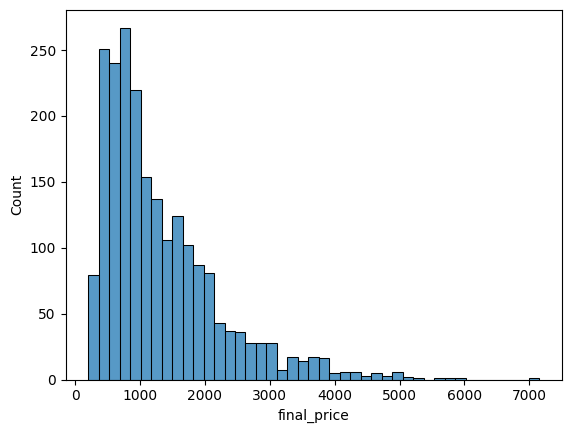

In [5]:
sns.histplot(df['final_price']);

## Missing values

In [6]:
df_new.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

In [7]:
df_new.describe()

,ram,storage,screen,final_price
count,2160.000000,2160.000000,2156.000000,2160.000000
mean,15.413889,596.294444,15.168112,1312.638509
std,9.867815,361.220506,1.203329,911.475417
min,4.000000,0.000000,10.100000,201.050000
25%,8.000000,256.000000,14.000000,661.082500
50%,16.000000,512.000000,15.600000,1031.945000
75%,16.000000,1000.000000,15.600000,1708.970000
max,128.000000,4000.000000,18.000000,7150.470000


In [8]:
df_new['ram'].median()

np.float64(16.0)

Prepare and split the dataset

In [9]:
n = len(df_new)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

In [10]:
np.random.seed(42)
idx = np.arange(n)
np.random.shuffle(idx)

In [11]:
df_train = df_new.iloc[idx[:n_train]]
df_val = df_new.iloc[idx[n_train:n_train+n_val]]
df_test = df_new.iloc[idx[n_train+n_val:]]

In [12]:
len(df_train), len(df_val), len(df_test)

(1296, 432, 432)

In [13]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [14]:
y_train = df_train.final_price
y_val = df_val.final_price
y_test = df_test.final_price

In [15]:
del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

## Regularization

In [16]:
def train_linear_regression(X, y):
    one = np.ones(X.shape[0])
    X = np.column_stack([one, X])
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]

In [17]:
def prepare_X(df):
    df = df.fillna(0)
    X = df.values
    return X

mean_values = df_train.mean()
screen_mean = mean_values['screen']

def prepare_mean_na(df):
    df = df.fillna(screen_mean)
    X = df.values
    return X

In [18]:
def rmse(y, y_pred):
    error = y - y_pred
    se = error ** 2
    mse = se.mean()
    rmse_error = np.sqrt(mse)
    return rmse_error

In [19]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
round(rmse(y_val, y_pred),5)

np.float64(597.36356)

In [20]:
X_train = prepare_mean_na(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_mean_na(df_val)
y_pred = w0 + X_val.dot(w)
round(rmse(y_val, y_pred),5)

np.float64(600.26503)

In [21]:
def linear_regression_regularized(X, y, r):
    one = np.ones(X.shape[0])
    X = np.column_stack([one, X])
    
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [22]:
for i in [0, 0.01, 0.1, 1, 5, 10, 100]:
    X_train = prepare_X(df_train)
    w0, w = linear_regression_regularized(X_train, y_train, r=i)
    
    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    
    print(f"regularization:{i}, bias:{w0}, RMSE:{score:.2f}")

regularization:0, bias:676.8954853003995, RMSE:597.36
regularization:0.01, bias:676.2736817205587, RMSE:597.36
regularization:0.1, bias:670.7284836314063, RMSE:597.35
regularization:1, bias:619.9030834108207, RMSE:597.21
regularization:5, bias:463.7771697142356, RMSE:597.01
regularization:10, bias:352.79713367679835, RMSE:597.06
regularization:100, bias:66.92071440181994, RMSE:597.90


## RMSE spread

In [23]:
score = []
for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    np.random.seed(seed)
    
    idx = np.arange(n)
    np.random.shuffle(idx)
    
    df_train = df_new.iloc[idx[:n_train]].reset_index(drop=True)
    df_val = df_new.iloc[idx[n_train:n_train+n_val]].reset_index(drop=True)
    df_test = df_new.iloc[idx[n_train+n_val:]].reset_index(drop=True)
    
    y_train = df_train.final_price.values
    y_val = df_val.final_price.values
    
    df_train = df_train.drop('final_price', axis=1)
    df_val = df_val.drop('final_price', axis=1)
    
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression(X_train, y_train)

    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    rmse_val = rmse(y_val, y_pred)
    score.append(rmse_val)

In [24]:
np.std(score)

np.float64(29.17649125829274)

## RMSE on Test

In [25]:
np.random.seed(9)

idx = np.arange(n)
np.random.shuffle(idx)
    
df_train = df_new.iloc[idx[:n_train]].reset_index(drop=True)
df_val = df_new.iloc[idx[n_train:n_train+n_val]].reset_index(drop=True)
df_test = df_new.iloc[idx[n_train+n_val:]].reset_index(drop=True)

final_df = pd.concat([df_train, df_val]).reset_index(drop=True)

y_final = final_df['final_price']
y_test = df_test.final_price.values
    
train_df = final_df.drop('final_price', axis=1)
test_df = df_test.drop('final_price', axis=1)
    
X_train = prepare_X(train_df)
w0, w = linear_regression_regularized(X_train, y_final, r=0.001)

X_test = prepare_X(test_df)
y_pred = w0 + X_test.dot(w)
rmse_val = round(rmse(y_test, y_pred), 2)
print(rmse_val)

608.61


## [EDA] Test 2

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

Preparing the dataset

In [2]:
df = pd.read_csv('laptops.csv')
len(df)

2160

In [4]:
df.head(10)

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01
5,MSI Crosshair 17 C12VF-264XES Intel Core i7-12...,New,MSI,Crosshair,Intel Core i7,32,1000,SSD,RTX 4060,17.3,No,1699.00
6,Lenovo Thinkpad E14 Gen 4 AMD Ryzen 5 5625U/8G...,New,Lenovo,ThinkPad,AMD Ryzen 5,8,256,SSD,NaN,14.0,No,909.00
7,ASUS VivoBook 15 F515JA-EJ2882W Intel Core i7-...,New,Asus,VivoBook,Intel Core i7,8,512,SSD,NaN,15.6,No,809.01
8,Medion Akoya E15415 Intel Core i5-10210U/8GB/2...,New,Medion,Akoya,Intel Core i5,8,256,SSD,NaN,15.6,No,519.00
9,HP Victus 16-d1038ns Intel Core i7-12700H/16GB...,New,HP,Victus,Intel Core i7,16,512,SSD,RTX 3050,16.1,No,1149.00


In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns

Index(['laptop', 'status', 'brand', 'model', 'cpu', 'ram', 'storage',
       'storage_type', 'gpu', 'screen', 'touch', 'final_price'],
      dtype='object')

In [7]:
df_redux = df[['ram', 'storage', 'screen', 'final_price']]
df_redux.head(10)

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01
5,32,1000,17.3,1699.00
6,8,256,14.0,909.00
7,8,512,15.6,809.01
8,8,256,15.6,519.00
9,16,512,16.1,1149.00


## EDA

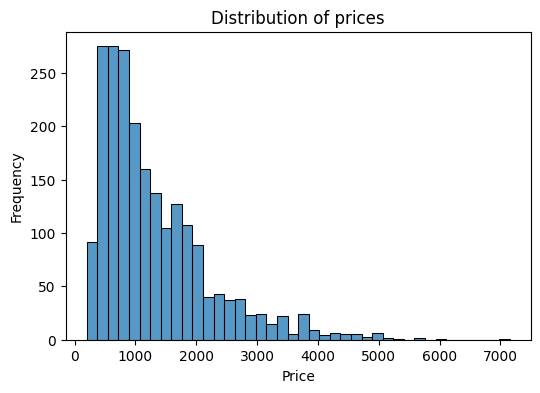

In [8]:
plt.figure(figsize=(6, 4))

sns.histplot(df_redux.final_price, bins=40)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

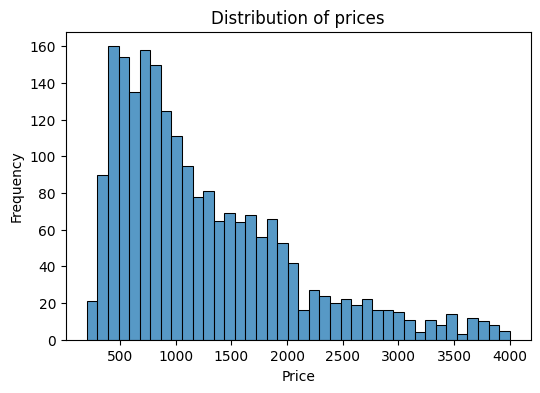

In [9]:
plt.figure(figsize=(6, 4))

sns.histplot(df_redux.final_price[df_redux.final_price < 4000], bins=40)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

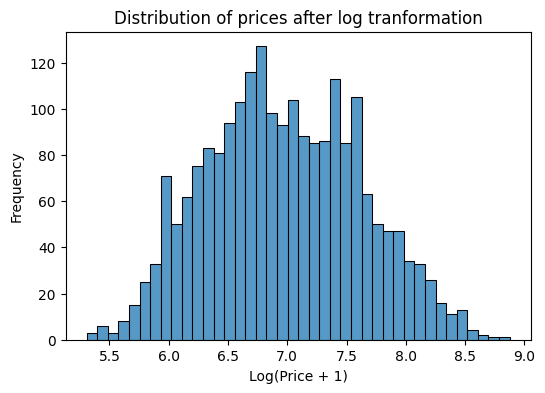

In [10]:
log_price = np.log1p(df_redux.final_price)

plt.figure(figsize=(6, 4))

sns.histplot(log_price, bins=40)
plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Distribution of prices after log tranformation')

plt.show()

### 1. Missing values

In [11]:
df_redux.isna().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

### 2. Median for RAM

In [12]:
print(df_redux['ram'].median())

16.0


## Prepare and split the dataset

In [13]:
n = len(df_redux)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

In [14]:
def prepare_datasets(seed):    
    np.random.seed(seed)
    idx = np.arange(len(df_redux))
    np.random.shuffle(idx)

    df_shuffled = df_redux.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train + n_val].copy()
    df_test = df_shuffled.iloc[n_train + n_val:].copy()

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    # df_train.fillna(0, inplace=True)
    # df_val.fillna(0, inplace=True)
    # df_test.fillna(0, inplace=True)

    y_train = df_train.final_price.values
    y_val = df_val.final_price.values
    y_test = df_test.final_price.values

    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']

    return df_train, y_train, df_val, y_val, df_test, y_test

In [15]:
 df_train, y_train, df_val, y_val, df_test, y_test = prepare_datasets(42)

In [16]:
len(df_train), len(df_val), len(df_test)

(1296, 432, 432)

### 3. Filling NAs

In [17]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [18]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    rmse = np.sqrt(mse)
    score = rmse.round(2)
    return score

### Option 1. Fill 'screen' missing values with 0

In [19]:
df1_train = df_train.copy()
X1_train = df1_train.fillna(0).values
w0, w = train_linear_regression(X1_train, y_train)

df1_val = df_val.copy()
X1_val = df1_val.fillna(0).values
y_pred = w0 + X1_val.dot(w)
print(rmse(y_val, y_pred))

597.36


In [ ]:
### Option 2: Fill 'screen' missing values with the mean from df_train

In [20]:
df2_train = df_train.copy()
X2_train = df2_train.fillna(df_train['screen'].mean()).values
w0, w = train_linear_regression(X2_train, y_train)

df2_val = df_val.copy()
X2_val = df2_val.fillna(df_train['screen'].mean()).values
y_pred = w0 + X2_val.dot(w)
print(rmse(y_val, y_pred))

600.27


###  4. Regularization

In [21]:
def train_linear_regression_reg(X, y, r):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [22]:
for r in [0.0, 0.01, 0.1, 1, 5, 10, 100]:
    X_train = df_train.fillna(0).values
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    X_val = df_val.fillna(0).values
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    
    print('%6s' %r, w0, score)

   0.0 676.8954853003995 597.36
  0.01 676.2736817205587 597.36
   0.1 670.7284836314063 597.35
     1 619.9030834108207 597.21
     5 463.7771697142356 597.01
    10 352.79713367679835 597.06
   100 66.92071440181994 597.9
